In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [3]:
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_CaOH_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

In [4]:
using MAT

size_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_20240124\\intensity.mat"
size_file = matread(size_file_path);

numbers_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_20240124\\intensity_numbers.mat"
numbers_file = matread(numbers_file_path);
 
temperature_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_Temperature_20240130\\temperatures.mat"
temperature_file = matread(temperature_file_path);

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_20240124\\simulations_diffusion.mat";

In [5]:
widths_x = size_file["widths_x"];
d_widths_x = size_file["widths_errors_x"];
widths_y = size_file["widths_y"];
d_widths_y = size_file["widths_errors_y"];

data_size = (widths_x.^2 .* widths_y).^(1/3)
d_data_size = sqrt.((2/3 .* d_widths_x ./ widths_x).^2 + (1/3 .* d_widths_y ./ widths_y).^2) .* data_size

data_signal = numbers_file["ampx1"];
d_data_signal = numbers_file["ampx1_errors"];

data_temperature = real.(temperature_file["temps"]);
d_data_temperature = real.(temperature_file["temp_errors"]);

voltages = size_file["all_params"]'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.3
 0.5
 0.7
 0.9
 1.1
 1.3
 1.5
 1.7
 1.9
 2.1

In [6]:
saving_path = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_no_diffusion200.jl"

"C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_no_diffusion200.jl"

In [7]:
voltages1 = 0.1:0.1:2.0;

In [9]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 50e-3 "mK"
diameter = @with_unit 0.1 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -72; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ4 = 0.0
Δ5 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

r1 = 3.7
r3 = 2.8 
r2 = 3.5

# r1 = 1
# r3 = 0.5
# r2 = 0

p1 = r1/(r1+r2+r3) * power_total
p3 = r3/(r1+r2+r3) * power_total
p2 = r2/(r1+r2+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 2 * p2 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 0.0
s5 = 0.0



blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 100,
                                pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,

                                diffusion_constant =0.0)
;

In [12]:

# results_list = []
scattering_rates = []
diffusion_constants = []

for intensity_voltage in voltages1
    power_total = intensity_voltage * 13.1 # mW

    p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
    p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
    p2 = 3.5/(3.7 + 2.8 + 3.5) * power_total

    s1 = 2 * p1 / (π * 0.5^2) / 3.4
    s3 = 2 * p3 / (π * 0.5^2) / 3.4
    s2 = 2 * p2 / (π * 0.5^2) / 3.4

    @printf("intensity voltage = %.1f V", intensity_voltage)
    
    blue_MOT_params.s1 = s1
    blue_MOT_params.s2 = s2
    blue_MOT_params.s3 = s3
    
    sequence = [blue_MOT_params]
    durations = [5e-3]
    generate_sequence!(sequence, durations)

    @time results = simulate_particles_constant_diffusion(package, package_A, sequence);
    sr = plot_scattering_rate(results)
    push!(scattering_rates, sr)
    @printf("Scattering rate = %.3f MHz \n", sr)
     
    ~,diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=5e-4, n_particles=60, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=60e-6)

    push!(diffusion_constants, diffusion_constant)
    @printf("Diffusion constant = %.3f \n", diffusion_constant)
    
#     serialize(saving_path, results_list)

#     @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))
    
    println()
    println()
end

intensity voltage = 0.1 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03

 63.430163 seconds (183.60 k allocations: 37.949 MiB)


Scattering rate = 0.582 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:44


Diffusion constant = 0.049 


intensity voltage = 0.2 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


 66.859579 seconds (180.66 k allocations: 37.722 MiB)


Progress:  28%|████████████                             |  ETA: 0:03:59

Scattering rate = 0.797 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:46


Diffusion constant = 0.087 


intensity voltage = 0.3 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


 70.161883 seconds (181.86 k allocations: 37.820 MiB)
Scattering rate = 0.834 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:48


Diffusion constant = 0.120 


intensity voltage = 0.4 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


 72.017231 seconds (181.23 k allocations: 37.776 MiB)
Scattering rate = 0.898 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:49


Diffusion constant = 0.146 


intensity voltage = 0.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


 79.381031 seconds (180.01 k allocations: 37.655 MiB)
Scattering rate = 0.885 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:50


Diffusion constant = 0.171 


intensity voltage = 0.6 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


 78.264093 seconds (181.81 k allocations: 37.800 MiB)


Progress:  33%|██████████████                           |  ETA: 0:03:41

Scattering rate = 0.903 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:53


Diffusion constant = 0.192 


intensity voltage = 0.7 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


 78.873033 seconds (182.04 k allocations: 37.836 MiB)
Scattering rate = 0.908 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:54


Diffusion constant = 0.212 


intensity voltage = 0.8 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


 84.968545 seconds (181.93 k allocations: 37.808 MiB)
Scattering rate = 0.971 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:53


Diffusion constant = 0.229 




Progress:  27%|████████████                             |  ETA: 0:01:23

intensity voltage = 0.9 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


 88.000499 seconds (182.06 k allocations: 37.821 MiB, 0.01% gc time)


Progress:  57%|████████████████████████                 |  ETA: 0:02:31

Scattering rate = 0.961 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:56


Diffusion constant = 0.246 




Progress:  17%|███████                                  |  ETA: 0:01:23

intensity voltage = 1.0 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


 87.131390 seconds (181.04 k allocations: 37.750 MiB)
Scattering rate = 1.000 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:56


Diffusion constant = 0.261 




Progress:  28%|████████████                             |  ETA: 0:01:25

intensity voltage = 1.1 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


 88.168972 seconds (180.81 k allocations: 37.740 MiB)
Scattering rate = 1.065 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:56


Diffusion constant = 0.276 




Progress:  46%|███████████████████                      |  ETA: 0:00:59

intensity voltage = 1.2 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


 91.490616 seconds (181.47 k allocations: 37.779 MiB, 0.01% gc time)
Scattering rate = 1.046 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:55


Diffusion constant = 0.290 


intensity voltage = 1.3 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


 93.108447 seconds (180.94 k allocations: 37.743 MiB)
Scattering rate = 1.063 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:56


Diffusion constant = 0.303 


intensity voltage = 1.4 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


 97.371165 seconds (181.86 k allocations: 37.805 MiB)
Scattering rate = 1.128 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:53


Diffusion constant = 0.315 




Progress:  38%|████████████████                         |  ETA: 0:01:03

intensity voltage = 1.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


 95.642608 seconds (180.98 k allocations: 37.742 MiB)
Scattering rate = 1.136 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:57


Diffusion constant = 0.328 


intensity voltage = 1.6 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


 97.511725 seconds (180.26 k allocations: 37.692 MiB)


Scattering rate = 1.193 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:56


Diffusion constant = 0.338 


intensity voltage = 1.7 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


101.198057 seconds (179.96 k allocations: 37.664 MiB)
Scattering rate = 1.231 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:58


Diffusion constant = 0.347 




Progress:  11%|█████                                    |  ETA: 0:02:35

intensity voltage = 1.8 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


102.012185 seconds (181.61 k allocations: 37.795 MiB)
Scattering rate = 1.264 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:56


Diffusion constant = 0.359 


intensity voltage = 1.9 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


103.185013 seconds (181.22 k allocations: 37.756 MiB)
Scattering rate = 1.323 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:53


Diffusion constant = 0.369 


intensity voltage = 2.0 V

Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


102.770853 seconds (181.29 k allocations: 37.747 MiB)


Progress:   8%|████                                     |  ETA: 0:17:19

Scattering rate = 1.302 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:04:57


Diffusion constant = 0.378 




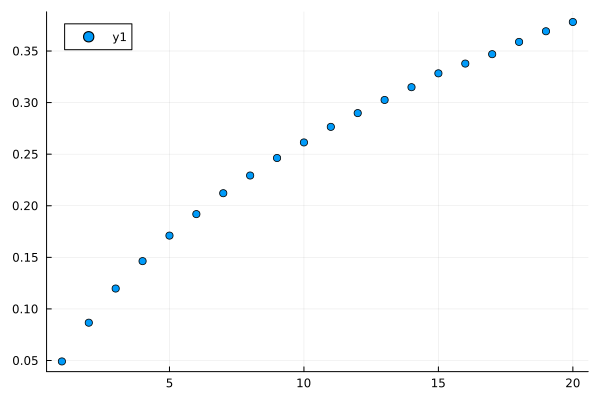

In [15]:
scatter(diffusion_constants)

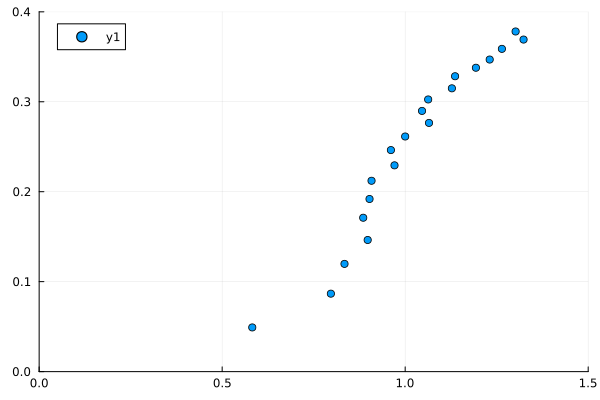

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


In [19]:
scatter(scattering_rates, diffusion_constants, ylim=[0,0.4], xlim=[0,1.5])

In [9]:
results_list = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_constant_diffusion1000_1.jl");
results_list_1 = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_constant_diffusion1000.jl");

In [11]:
merged_list= merge_result_lists([results_list, results_list_1]);

In [48]:
merged_list = results_list;

0.0864552223361223
0.0433730539396158
0.03649458947829098
0.03539243828983878
0.03291325869389322
0.034952766730934594
0.04120528708936381
0.0401258203818816
0.0409444860791277
0.04501025091277305
0.04528521004573641
0.04789369503323686
0.04851138799229375
0.054116003108648024
0.05154527538034893
0.057720486435958514
0.06248936151353228
0.06764970843450184
0.06535000838930259
0.06541131960608183


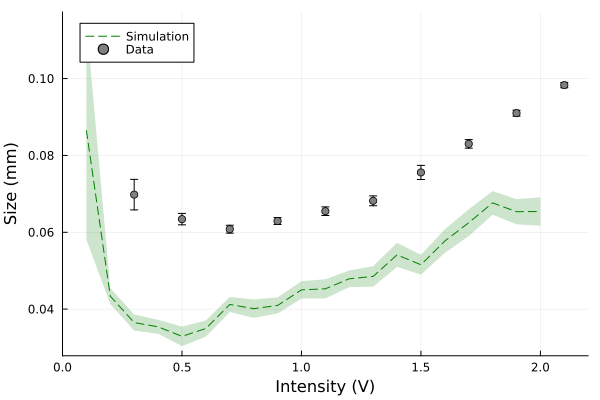

In [51]:
sizes = []
size_errors = []
for results in merged_list[1:end]
    size, error = bootstrap_size_fit(results, 5; iter=100, n_grids=40, range=0.18)
    println(size)
    push!(sizes, size)
    push!(size_errors, error)
end

plot(voltages1, sizes,color="green",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation",
ribbon=(size_errors, size_errors),fc=:green,fa=0.2)

scatter!(voltages, data_size, yerr=d_data_size, label="Data", color="gray")
plot!(xlim=[0,2.2])

In [52]:
signals = []
signal_errors = []

for results in merged_list[1:end]
    signal, error = bootstrap_survival(results,5, iter=100, n_values=500)
    push!(signals, signal)
    push!(signal_errors, error)
end
    
plot(voltages, signals,color="green", linestyle=:dash, xlabel="Intensity (V)", ylabel="Survival",label="Simulation",
ribbon=(signal_errors, signal_errors),fc=:green,fa=0.2)



# signals1 = []
# signal1_errors = []
# for results in results_list_imperfection[1:end]
#     signal1, error = bootstrap_survival(results; iter=100)
#     push!(signals1, signal1)
#     push!(signal1_errors, error)
# end

# plot!(voltages, signals1,color="red",linestyle=:dash, label="Simulation with imperfection",
# ribbon=(signal1_errors, signal1_errors),fc=:red,fa=0.2)
scatter!(voltages, data_signal./maximum(data_signal)*0.6, yerr=d_data_signal, color="gray", label="data")
plot!(xlim=[0,2.2])

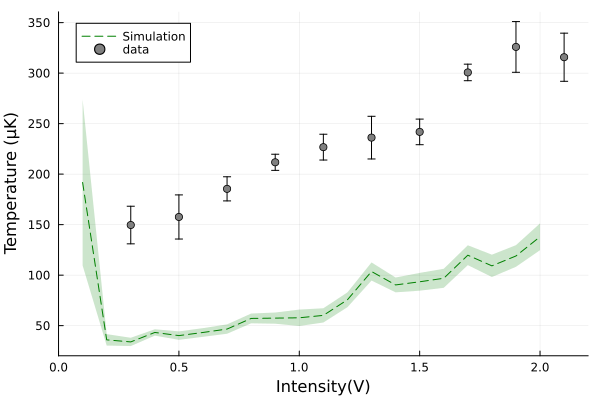

In [53]:
temperatures = []
temperature_errors = []
t_end = 5e-3

for results in merged_list[1:end]
    temp, error = bootstrap_temperature_fit(results,5; iter=100, n_grids=40, range=0.5)
    push!(temperatures, temp)
    push!(temperature_errors, error)
end
    
plot(voltages1, temperatures,color="green",linestyle=:dash, xlabel="Intensity(V)", ylabel="Temperature (μK)",label="Simulation",
ribbon=(temperature_errors, temperature_errors),fc=:green,fa=0.2)



# temperatures1 = []
# temperature1_errors = []
# for results in results_list_imperfection[1:end]
#     temp, error = bootstrap_temperature_fit(results; iter=100)
#     push!(temperatures1, temp)
#     push!(temperature1_errors, error)
# end

# plot!(voltages, temperatures1,color="red",linestyle=:dash, label="Simulation with imperfection",
# ribbon=(temperature1_errors, temperature1_errors),fc=:red,fa=0.2)


scatter!(voltages, data_temperature.*1e6, yerr=d_data_temperature.*1e6, color="gray", label="data")
plot!(xlim=[0,2.2])

In [20]:
file = matopen(simulation_file_path, "w")
write(file, "simulation_sizes", sizes)
write(file, "simulation_size_errors", size_errors)

write(file, "simulation_signals", signals)
write(file, "simulation_signal_errors", signal_errors)

write(file, "simulation_temperatures", temperatures)
write(file, "simulation_temperature_errors", temperature_errors)

# write(file, "simulation_sizes_imperfection", sizes1)
# write(file, "simulation_size_errors_imperfection", size1_errors)

# write(file, "simulation_signals_imperfection", signals1)
# write(file, "simulation_signal_errors_imperfection", signal1_errors)

# write(file, "simulation_temperatures_imperfection", temperatures1)
# write(file, "simulation_temperature_errors_imperfection", temperature1_errors)
close(file);

In [56]:
SVector(1,2,3.0)

3-element SVector{3, Float64} with indices SOneTo(3):
 1.0
 2.0
 3.0